# Randomized Benchmarking

In [1]:
import numpy as np
from qutip import tensor, basis, ket2dm, fidelity
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations.gates import rz
from chalmers_qubit.sarimner import (
    SarimnerProcessor,
    SarimnerModel,
    SarimnerCompiler,
    DecoherenceNoise,
)
from chalmers_qubit.base.operations import project_on_qubit

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%load_ext autoreload
%autoreload 2

## Single-qubit Clifford Randomized Benchmarking

Setup device

In [2]:
transmon_dict = {
    0: {"frequency": 5.02, "anharmonicity": -0.3},
    1: {"frequency": 4.82, "anharmonicity": -0.3},
}
decoherence_dict = {
    0: {"t1": 60e3, "t2": 100e3},
    1: {"t1": 60e3, "t2": 100e3},
}
# Set up the model, compiler, and processor
model = SarimnerModel(transmon_dict=transmon_dict)
compiler = SarimnerCompiler(model=model)
noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)

In [ ]:
from chalmers_qubit.utils import randomized_benchmarking_sequence, randomized_benchmarking_circuit

# Generate the randomized benchmarking sequence
sequence = randomized_benchmarking_sequence(
    number_of_cliffords=10,
    apply_inverse=True,
    clifford_group=2,
    seed=123,
)
sequence
#circuit = randomized_benchmarking_circuit(clifford_indices=sequence, targets=0)
#circuit

array([  177,  7860,  6830,   620, 10472,  2538,  2938,  2123,  3843,
        2026])

## Loop over Sequences

We now create the single-qubit Clifford group, using the XY-decomposition

Gate decomposition decomposition of the clifford group as per [Epstein et al. Phys. Rev. A 89, 062321 (2014)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.89.062321)

In [32]:
targets = 0

for target in targets:
    print(target)

TypeError: 'int' object is not iterable

In [13]:
from chalmers_qubit.utils import randomized_benchmarking_sequence, randomized_benchmarking_circuit

interleaved_clifford_idx = 16
sequences = [8, 64, 128, 256, 512]
sequence_fidelity = []
interleaved_sequence_fidelity = []

# Set up the model, compiler, and processor
model = SarimnerModel(transmon_dict=transmon_dict)
options = {
    "dt": 1,  # in (ns)
}
compiler = SarimnerCompiler(model=model, options=options)
noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)

# Loop over sequence lengths
for m in sequences:
    print(f"Running sequence length {m}")
    
    # Generate the randomized benchmarking sequence
    clifford_indices = randomized_benchmarking_sequence(
        number_of_cliffords=m,
        apply_inverse_gate=True,
        clifford_group=1,
        seed=None
    )

    interleaved_clifford_indices = randomized_benchmarking_sequence(
        number_of_cliffords=m,
        apply_inverse_gate=True,
        interleaved_clifford_idx=interleaved_clifford_idx,
        clifford_group=1,
        seed=None
    )

    # Compile clifford indices to a quantum circuit
    rb_circuit = randomized_benchmarking_circuit(clifford_indices=clifford_indices)
    rb_interleaved_circuit = randomized_benchmarking_circuit(clifford_indices=interleaved_clifford_indices)
    
    # Simulate the quantum circuit and compute the probability of remaning in the initial state
    init_state = basis(3,0)
    result = sarimner.run_state(init_state=init_state, qc=rb_circuit)
    result_interleaved = sarimner.run_state(init_state=init_state, qc=rb_interleaved_circuit)

    final_state = result.states[-1]
    final_state_interleaved = result_interleaved.states[-1]

    # Compute the survival probability
    sequence_fidelity.append(fidelity(init_state, final_state))
    interleaved_sequence_fidelity.append(fidelity(init_state, final_state_interleaved))

Running sequence length 8
Running sequence length 64
Running sequence length 128
Running sequence length 256
Running sequence length 512


### Fit the data to an exponential decay

A = 0.33001039796717874, p = 0.9991675911797845, B = 0.670544721711378
A (int) = 0.27090809937912597, p (int) = 0.9983092309075736, B (int) = 0.7294415888389654


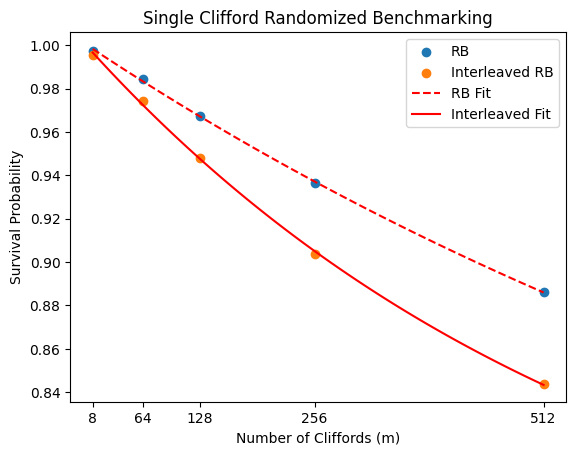

In [23]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the model function
def model(m, A, p, B) -> float:
    return A * p**m + B

# Initial guess for A, p, B
initial_guess = [1, 0.99, 0.5]

# Fit the curve
params, covariance = curve_fit(model, sequences, sequence_fidelity, p0=initial_guess)

# Fit the curve
params_interleaved, covariance_interleaved = curve_fit(model, sequences, interleaved_sequence_fidelity, p0=initial_guess)

# Extract fitted parameters
A_fit, p_fit, B_fit = params
print(f"A = {A_fit}, p = {p_fit}, B = {B_fit}")

A_interleaved_fit, p_interleaved_fit, B_interleaved_fit = params_interleaved
print(f"A (int) = {A_interleaved_fit}, p (int) = {p_interleaved_fit}, B (int) = {B_interleaved_fit}")

# Plot
x_fit = np.linspace(min(sequences), max(sequences), 100)
y_fit = model(x_fit, A_fit, p_fit, B_fit)

y_interleaved_fit = model(x_fit, A_interleaved_fit, p_interleaved_fit, B_interleaved_fit)

plt.scatter(sequences, sequence_fidelity, label="RB")
plt.scatter(sequences, interleaved_sequence_fidelity, label="Interleaved RB")
plt.plot(x_fit, y_fit, label="RB Fit", color='red', linestyle='--')
plt.plot(x_fit, y_interleaved_fit, label="Interleaved Fit", color='red')
plt.legend()
plt.xlabel("Number of Cliffords (m)")
plt.ylabel("Survival Probability")
plt.title("Single Clifford Randomized Benchmarking")
plt.xticks(sequences)
plt.show()


In [71]:
# Calculate average error per Clifford
d = 2
r_fit = (d-1)/d * (1-p_fit)
# Calculate the average errorb per single-qubit gate
r_sq = r_fit / 1.875
r_sq

0.002575080844858224

## Interleaved

## Work in progress

In [126]:
from qutip import average_gate_fidelity
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import RX
from chalmers_qubit.base.operations import project_on_qubit

arg_value = np.pi/2

circuit = QubitCircuit(1)
circuit.add_gate("RX", targets=[0], arg_value=arg_value)

# Set up the model, compiler, and processor
model = SarimnerModel(transmon_dict=transmon_dict)
options = {
        "dt": 1,  # in (ns)
    }
compiler = SarimnerCompiler(model=model, options=options)
noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)

# Simulate the quantum circuit and compute the probability of remaning in state |0>
init_state = basis(3,0)
tlist, coeffs = sarimner.load_circuit(circuit)
result = sarimner.run_propagator(init_state=init_state, options={"nsteps": 1e5}, noisy=True)
#final_prop = project_on_qubit(result)

ideal_gate = RX(targets=0, arg_value=arg_value).get_compact_qobj()
agf = average_gate_fidelity(final_prop, ideal_gate)
print(f"Average gate fidelity: {agf}")


Average gate fidelity: 0.9999999573985212


In [127]:
from qutip import Qobj

def modified_pauli_matrices():
    modified_pauli = []
    # Identity
    modified_pauli.append(Qobj(np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])))
    # Sigma X
    modified_pauli.append(Qobj(np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])))
    # Sigma Y
    modified_pauli.append(Qobj(np.array([[0, -1j, 0], [1j, 0, 0], [0, 0, 0]])))
    # Sigma Z
    modified_pauli.append(Qobj(np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]])))
    return modified_pauli

modified_pauli = modified_pauli_matrices()

In [136]:
def all_possible_combinations(matrices, num_qutrits):
    if num_qutrits == 1:
        return matrices
    else:
        prev_combinations = all_possible_combinations(matrices, num_qutrits - 1)
        new_combinations = []
        for m1 in matrices:
            for m2 in prev_combinations:
                new_combinations.append(tensor(m1, m2))
        return new_combinations

# Create all combinations of Paulis
all_paulis = all_possible_combinations(modified_pauli, num_qutrits=1)

In [ ]:
from tqdm import tqdm

arg_value = np.pi/2

circuit = QubitCircuit(1)
circuit.add_gate("RX", targets=[0], arg_value=arg_value)

# Compute the ideal unitary from the circuit
U = circuit.compute_unitary()

# Set up the model, compiler, and processor
model = SarimnerModel(transmon_dict=transmon_dict)
options = {
        "dt": 1,  # in (ns)
    }
compiler = SarimnerCompiler(model=model, options=options)
noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)

tlist, coeffs = sarimner.load_circuit(circuit)

# average gate fidelity
F = 0
# compute the average gate fidelity
for pauli in tqdm(all_paulis, desc="Computing average gate fidelity", unit="pauli operator"):
    # Run master equation simulation
    result = sarimner.run_state(pauli)
    # Project the modified Pauli onto the qubit subspace
    P = project_on_qubit(pauli)
    # Project the final state onto the qubit subspace
    M = project_on_qubit(result.states[-1])
    # Sum up the measurements to get the avg gate fid
    F += ((U*P.dag()*U.dag()*M).tr())

avg_gate_fid = ((F+d**2)/(d**2*(d+1))).real
print("Average gate fidelity",round(avg_gate_fid,3))


Computing average gate fidelity: 100%|██████████| 4/4 [00:00<00:00, 155.79pauli operator/s]

Average gate fidelity 0.667


## Interleaved RB

In [87]:
from qutip import to_super
rx = to_super(ideal_gate)